## 0. Imports

In [1]:
import pandas as pd
import numpy as np

from IPython.core.display import HTML
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score, accuracy_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [2]:
## Settings
def jupyter_settings():
    %matplotlib inline

    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24

    display(HTML('<style>.conteiner{width:100% !important;}</style>'))

    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    # configura o pandas para quantidade de casas decimeis
    pd.set_option('display.float_format', lambda x: '%.2f' % x)

    sns.set()
jupyter_settings()

## 1. Data preparation

### 1.1 Import the data


In [3]:
df = pd.read_csv('telco_churn.csv')

### 1.2 Format column names and values


In [4]:
df.columns = df.columns.str.lower().str.replace(' ','_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for column in categorical_columns:
    df[column] = df[column].str.lower().replace(' ','_')

In [5]:
df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce').fillna(0)

### 1.3 Check if the churn variable needs any preapration


In [6]:
df.churn = df.churn.map({'yes':1, 'no':0})

## 2. Validation Framework

### 2.1 Split data into train and test data


In [7]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)

### 2.2 Split train data into train and validation data


In [8]:
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [9]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_full_train = df_full_train.reset_index(drop=True)

### 2.3 Check datasets lengths


In [10]:
len(df_train), len(df_val), len(df_test)

(4225, 1409, 1409)

### 2.4 Separate features from target variable


In [11]:
y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

In [12]:
del df_train['churn']
del df_val['churn']
del df_test['churn']

## 3. Exploratory Data Analysis

### 3.1 Check missing values

In [13]:
df_full_train.isnull().sum()

customerid          0
gender              0
seniorcitizen       0
partner             0
dependents          0
tenure              0
phoneservice        0
multiplelines       0
internetservice     0
onlinesecurity      0
onlinebackup        0
deviceprotection    0
techsupport         0
streamingtv         0
streamingmovies     0
contract            0
paperlessbilling    0
paymentmethod       0
monthlycharges      0
totalcharges        0
churn               0
dtype: int64

### 3.2 Look at target variable (churn)


In [14]:
df_full_train.churn.value_counts(normalize=True)

0   0.73
1   0.27
Name: churn, dtype: float64

In [15]:
global_churn_rate = df_full_train.churn.mean()
global_churn_rate.round(2)

0.27

### 3.3 Look at numerical anda categorical variables


In [16]:
df_full_train.dtypes

customerid           object
gender               object
seniorcitizen         int64
partner              object
dependents           object
tenure                int64
phoneservice         object
multiplelines        object
internetservice      object
onlinesecurity       object
onlinebackup         object
deviceprotection     object
techsupport          object
streamingtv          object
streamingmovies      object
contract             object
paperlessbilling     object
paymentmethod        object
monthlycharges      float64
totalcharges        float64
churn                 int64
dtype: object

In [17]:
df_full_train.seniorcitizen = df_full_train.seniorcitizen.map({1:'yes',0:'no'})

In [18]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']
categorical = [x for x in list(df_full_train.columns) if x not in numerical][1:-1]

In [19]:
df_full_train[categorical].nunique()

gender              2
seniorcitizen       2
partner             2
dependents          2
phoneservice        2
multiplelines       3
internetservice     3
onlinesecurity      3
onlinebackup        3
deviceprotection    3
techsupport         3
streamingtv         3
streamingmovies     3
contract            3
paperlessbilling    2
paymentmethod       4
dtype: int64

### 3.4 Feature Importance

In [20]:
def groupby_churn(df, column):
    churn = df_full_train[[column,'churn']].groupby(column).mean().reset_index()
    #churn['difference'] = churn.churn.apply(lambda x: global_churn_rate - x)
    churn['risk_ratio'] = churn.churn.apply(lambda x: x/global_churn_rate)
    return churn

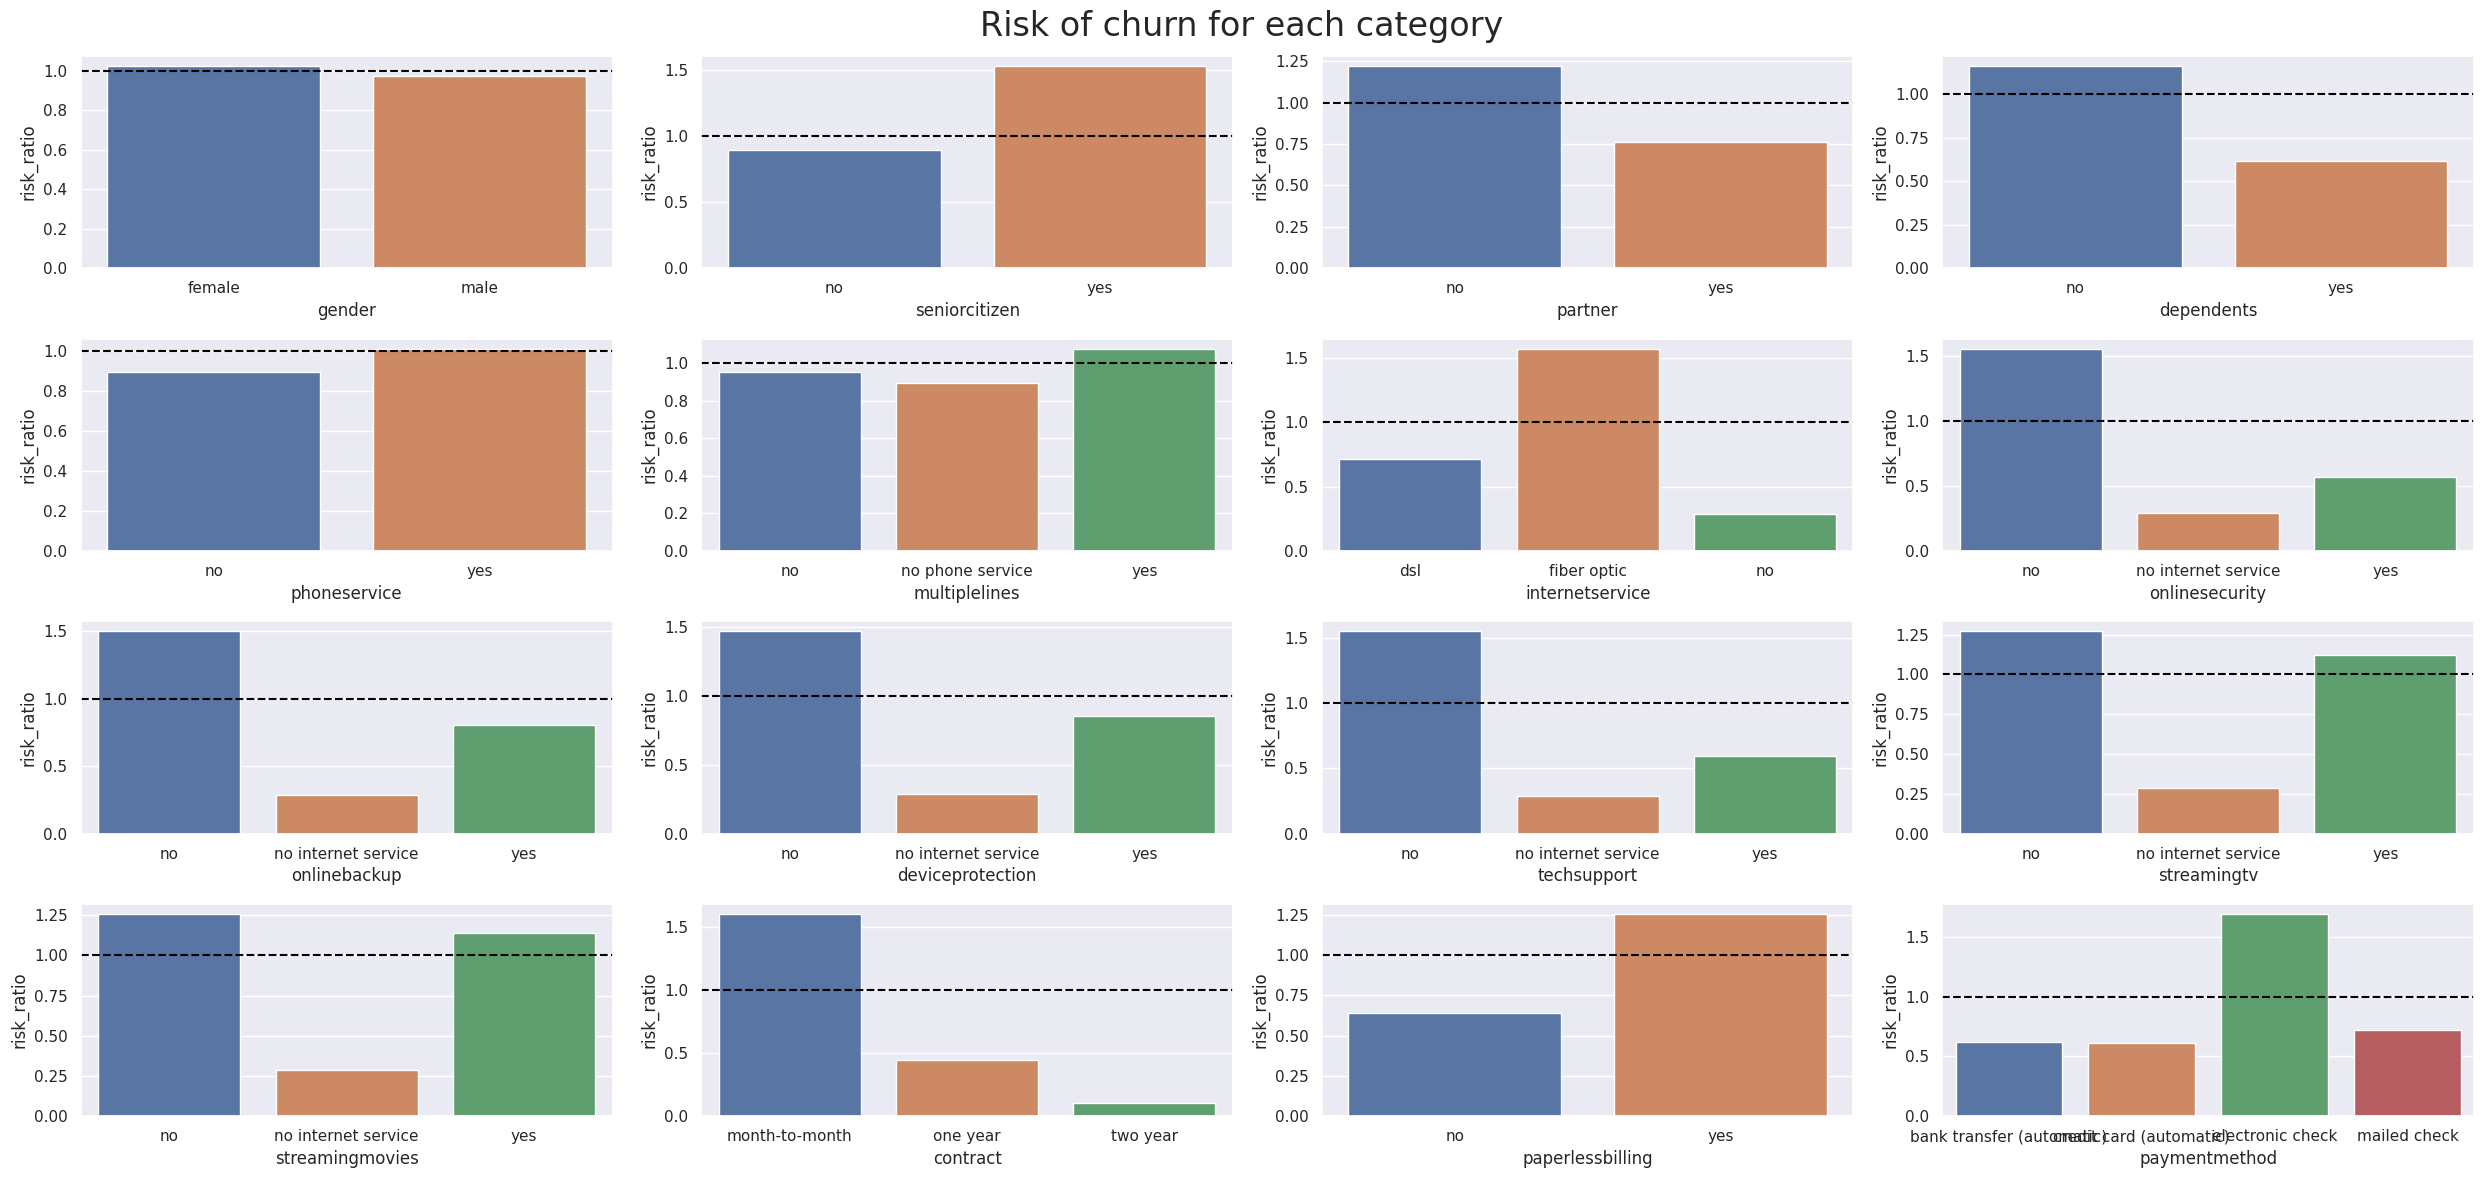

In [21]:
for index,column in enumerate(categorical):
    df_gb = groupby_churn(df_full_train, column)
    plt.subplot(4,4,index+1)
    sns.barplot(data=df_gb, x=column, y='risk_ratio')
    plt.axhline(1, linestyle='--', color='0')
plt.suptitle('Risk of churn for each category', fontsize=24)
plt.tight_layout()
plt.show()

- Mutual information (importance of categorical variables)

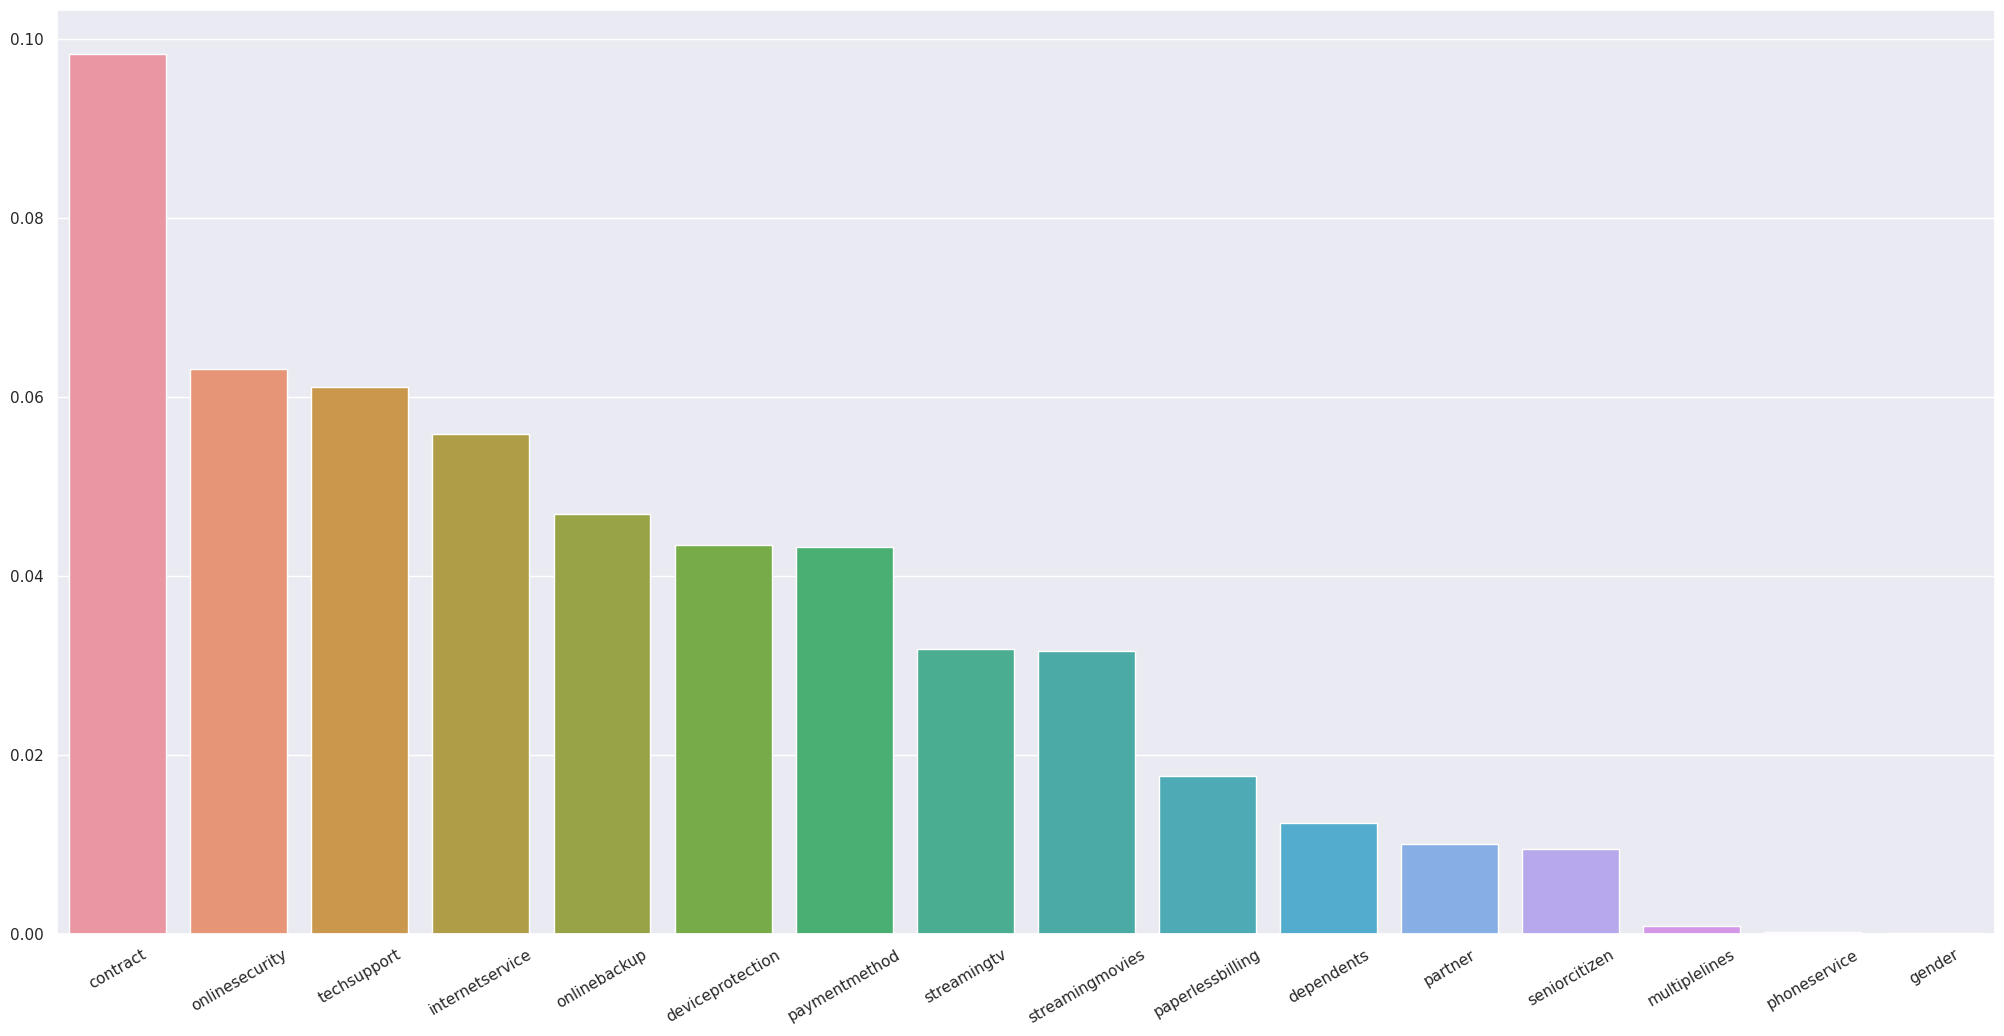

In [22]:
mutual_info = {}
for column in categorical:
    score = mutual_info_score(df_full_train.churn, df_full_train[column])
    mutual_info[column] = score
df_mutual = pd.Series(mutual_info).sort_values(ascending=False)
sns.barplot(x=df_mutual.index, y=df_mutual.values)
plt.xticks(rotation=30)
plt.show()

- Correlation ('Pearson' - importance of numerical variables)


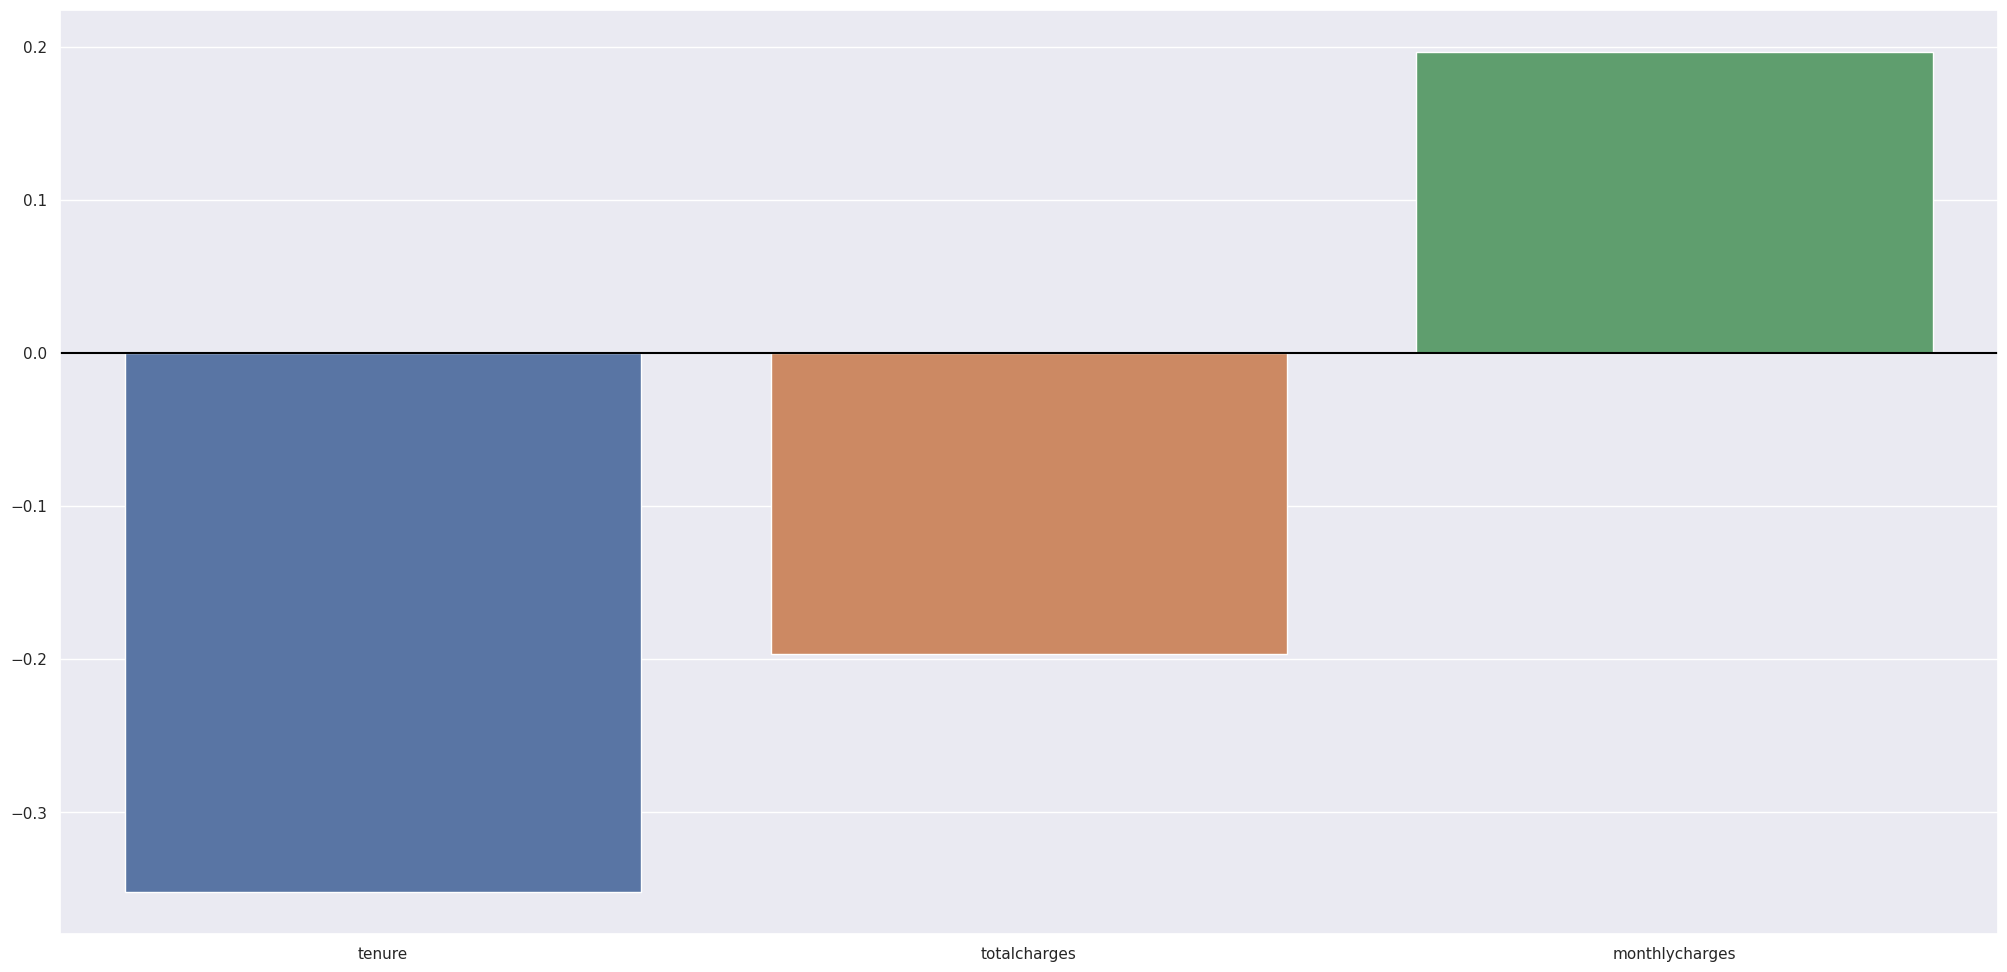

In [23]:
corr = df_full_train[numerical].corrwith(df_full_train.churn).sort_values()
sns.barplot(x=corr.index, y=corr.values)
plt.axhline(0, linestyle='-', color='0')
plt.show()

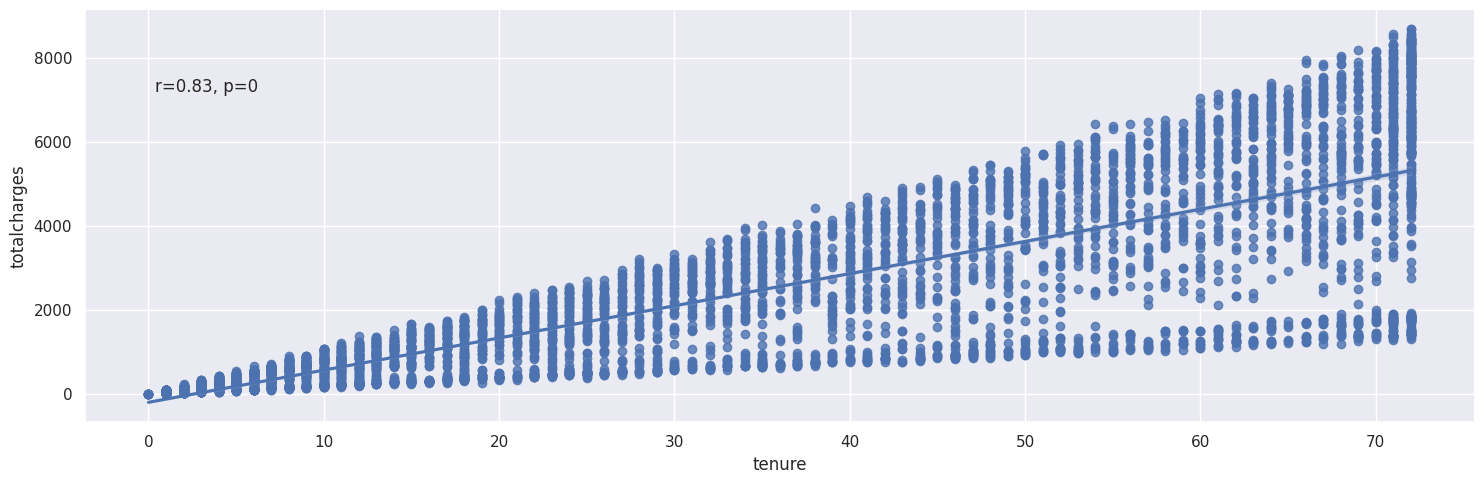

PearsonRResult(statistic=0.8282676242194342, pvalue=0.0)

In [24]:
import scipy as sp
def annotate(data, **kws):
    r, p = sp.stats.pearsonr(df_full_train.tenure.values, df_full_train.totalcharges.values)
    ax = plt.gca()
    ax.text(.05, .8, 'r={:.2f}, p={:.2g}'.format(r, p),
            transform=ax.transAxes)

g = sns.lmplot(data=df_full_train, x='tenure', y='totalcharges', aspect=3)
g.map_dataframe(annotate)
plt.show()

sp.stats.pearsonr(df_full_train.tenure.values, df_full_train.totalcharges.values)

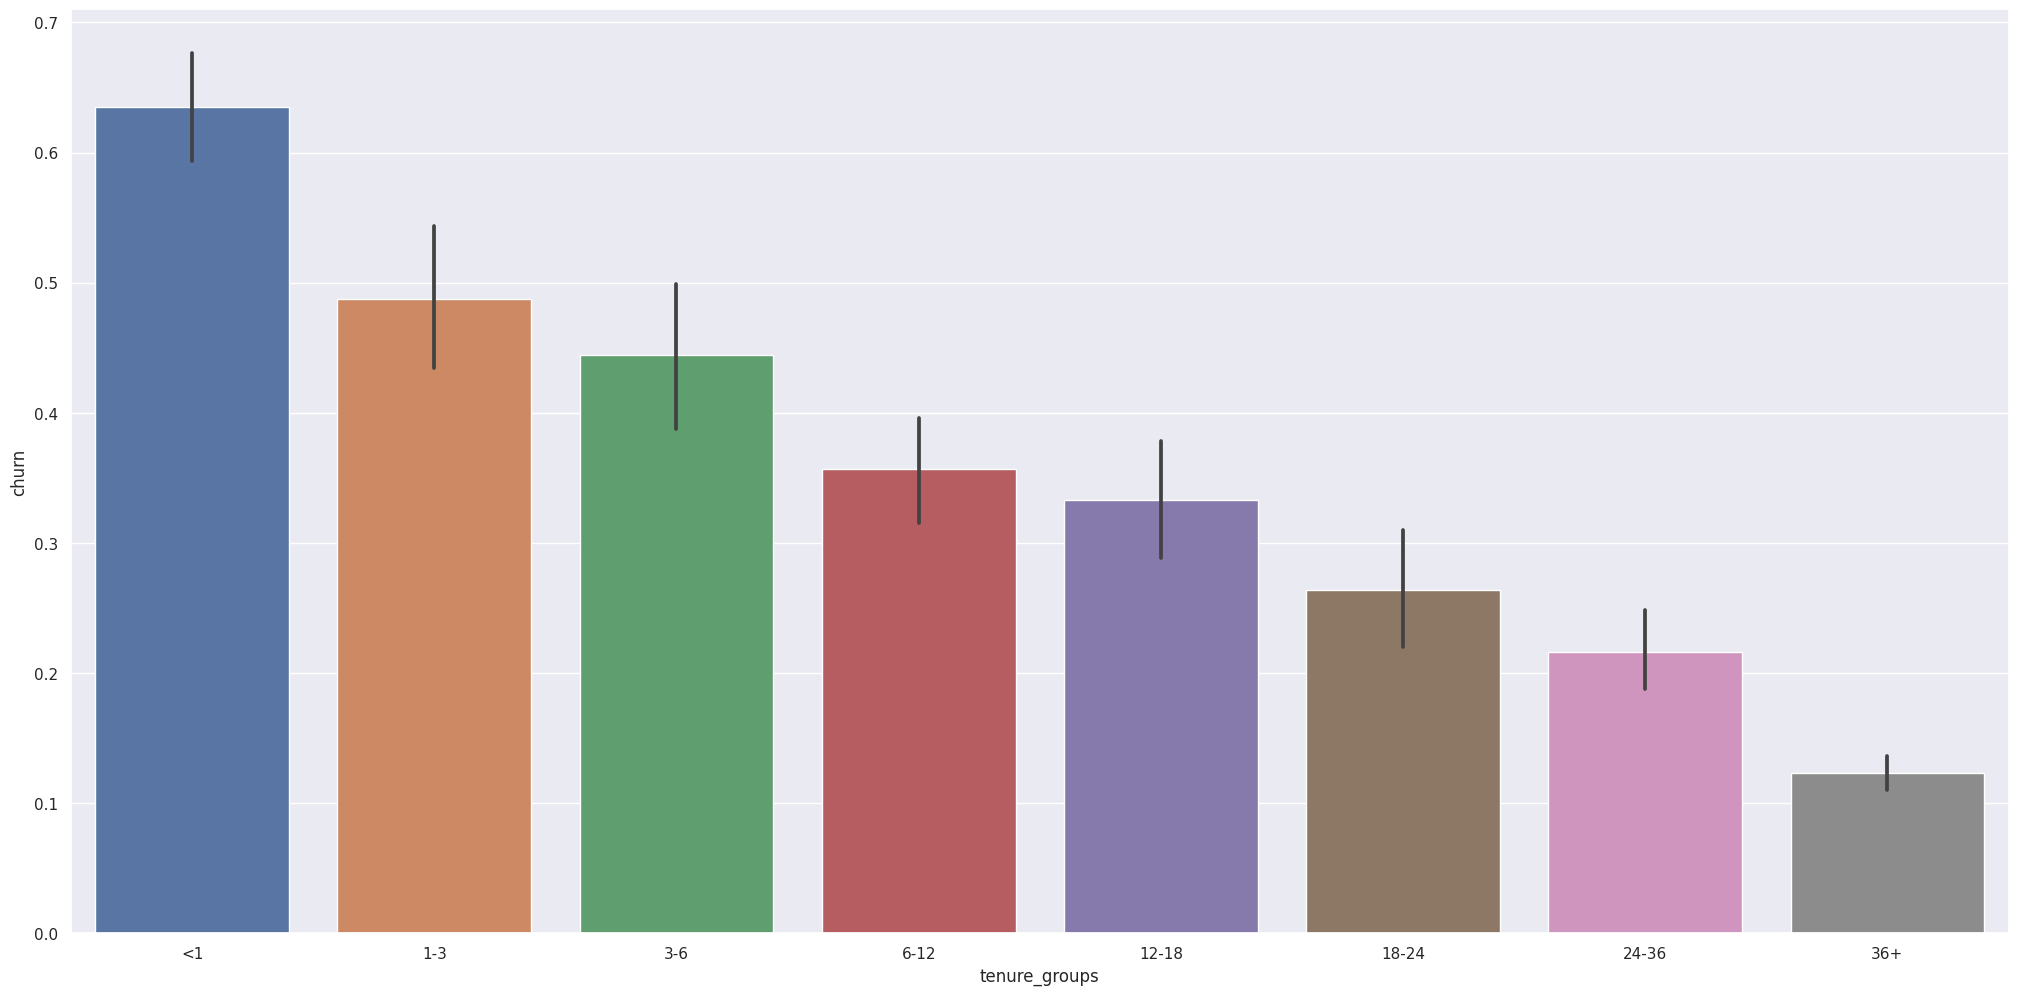

In [25]:
bins = [0, 1, 3, 6, 12, 18, 24, 36, np.inf]
names = ['<1', '1-3', '3-6', '6-12', '12-18', '18-24', '24-36', '36+']

df_full_train['tenure_groups'] = pd.cut(df_full_train.tenure, bins, labels=names)
sns.barplot(data=df_full_train, x='tenure_groups', y='churn');

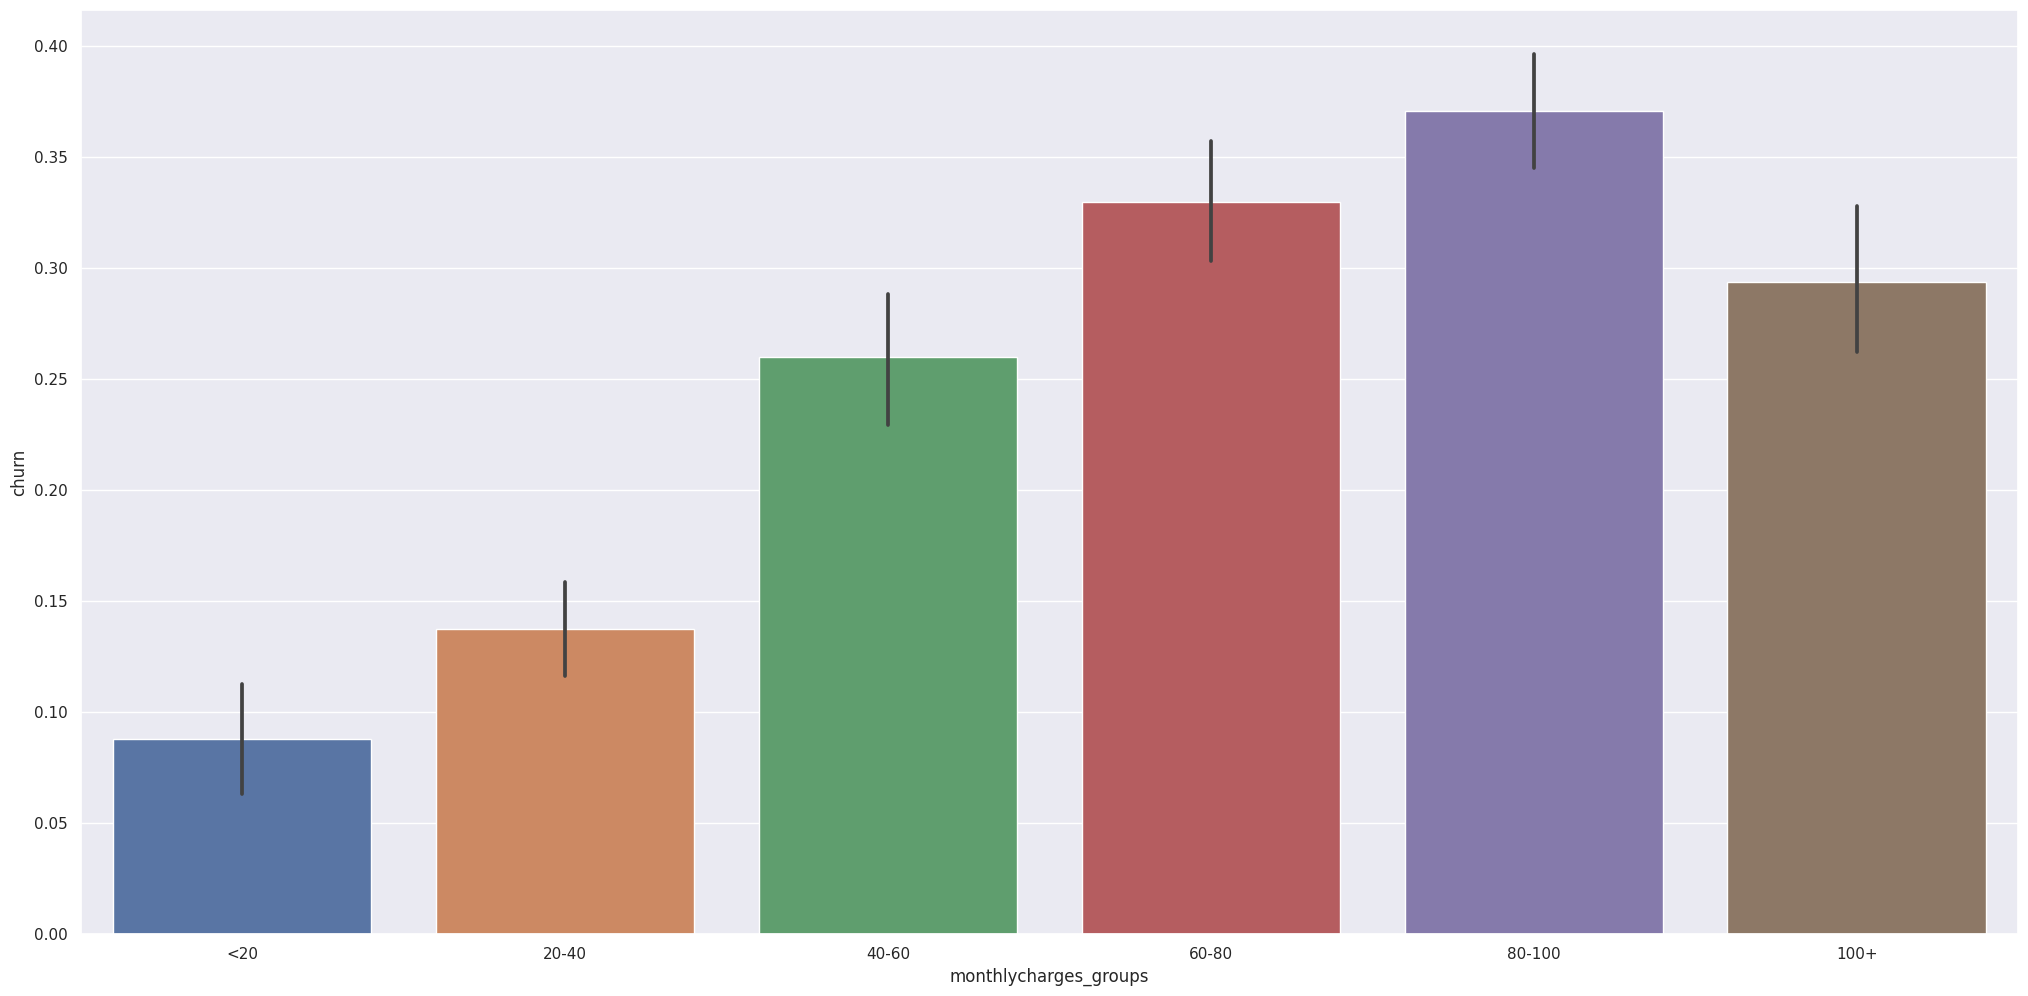

In [26]:
bins = [0, 20, 40, 60, 80, 100, np.inf]
names = ['<20', '20-40', '40-60', '60-80', '80-100', '100+']

df_full_train['monthlycharges_groups'] = pd.cut(df_full_train.monthlycharges, bins, labels=names)
sns.barplot(data=df_full_train, x='monthlycharges_groups', y='churn');

## 4. Variable encoding (One-Hot Encoding)

In [27]:
dv = DictVectorizer(sparse=False)

- Training data

In [28]:
train_dicts = df_train[categorical+numerical].to_dict(orient='records')

X_train = dv.fit_transform(train_dicts)

- Validation data

In [29]:
val_dicts = df_val[categorical+numerical].to_dict(orient='records')

X_val = dv.transform(val_dicts)

## 5. Train model (Logistic Regression)

In [30]:
model = LogisticRegression()
model.fit(X_train, y_train);

In [31]:
y_pred = model.predict_proba(X_val)[:,1]

threshold = 0.50
churn_decision = (y_pred >= threshold)

In [32]:
evaluation = accuracy_score(y_val, churn_decision)
evaluation

0.8034066713981547

## 6. Model interpretation

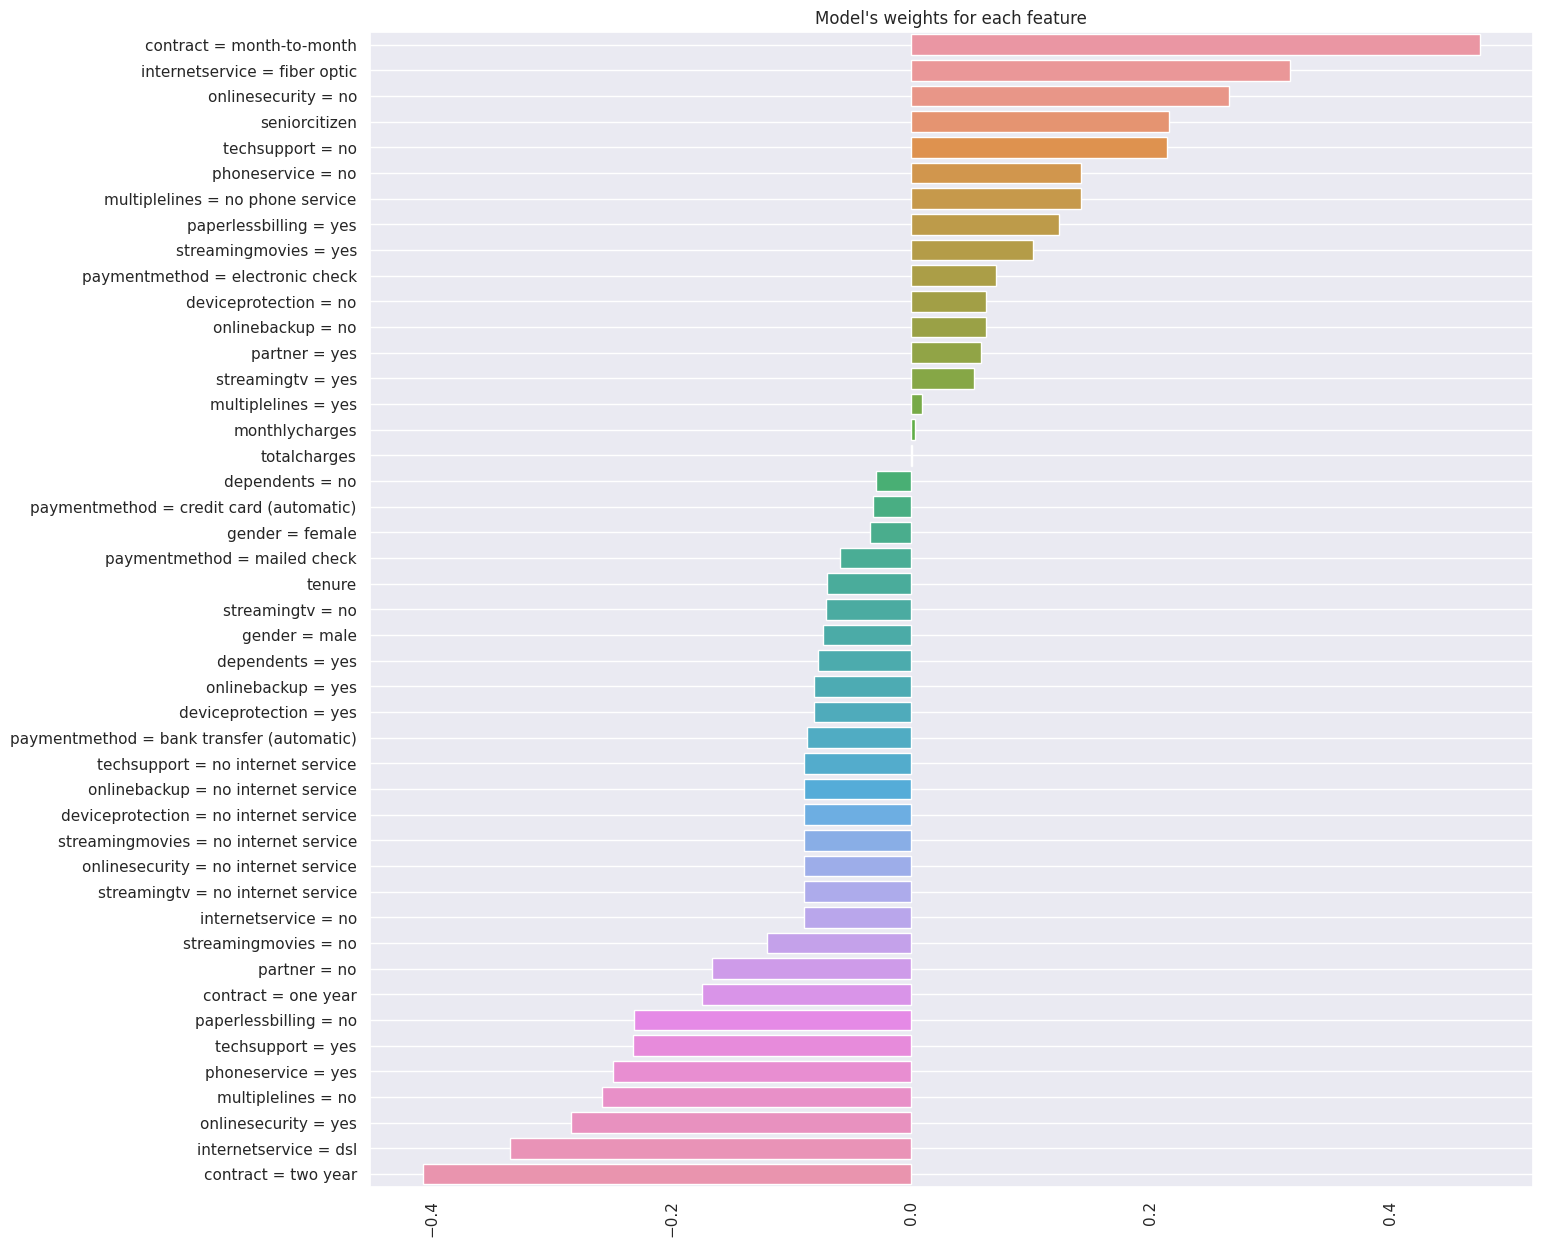

In [33]:
weights = pd.Series(dict(zip(dv.get_feature_names_out(), model.coef_[0]))).sort_values(ascending=False)
weights.index = [x.replace('=',' = ') for x in list(weights.index)]

plt.figure(figsize=(15,15))
plt.title("Model's weights for each feature")
sns.barplot(y=weights.index, x=weights.values)
plt.xticks(rotation=90)
ax = plt.gca()
ax.yaxis.grid(True) # Hide the horizontal gridlines
ax.xaxis.grid(False) # Show the vertical gridlines
plt.show()

- Trying smaller model

In [34]:
small = ['contract', 'tenure','monthlycharges']
small_dicts_train = df_train[small].to_dict(orient='records')
small_dicts_val = df_val[small].to_dict(orient='records')

dv_small = DictVectorizer(sparse=False)
dv_small.fit(small_dicts_train)

X_train_small = dv_small.transform(small_dicts_train)
X_val_small = dv_small.transform(small_dicts_val)

In [35]:
model_small = LogisticRegression()
model_small.fit(X_train_small, y_train);

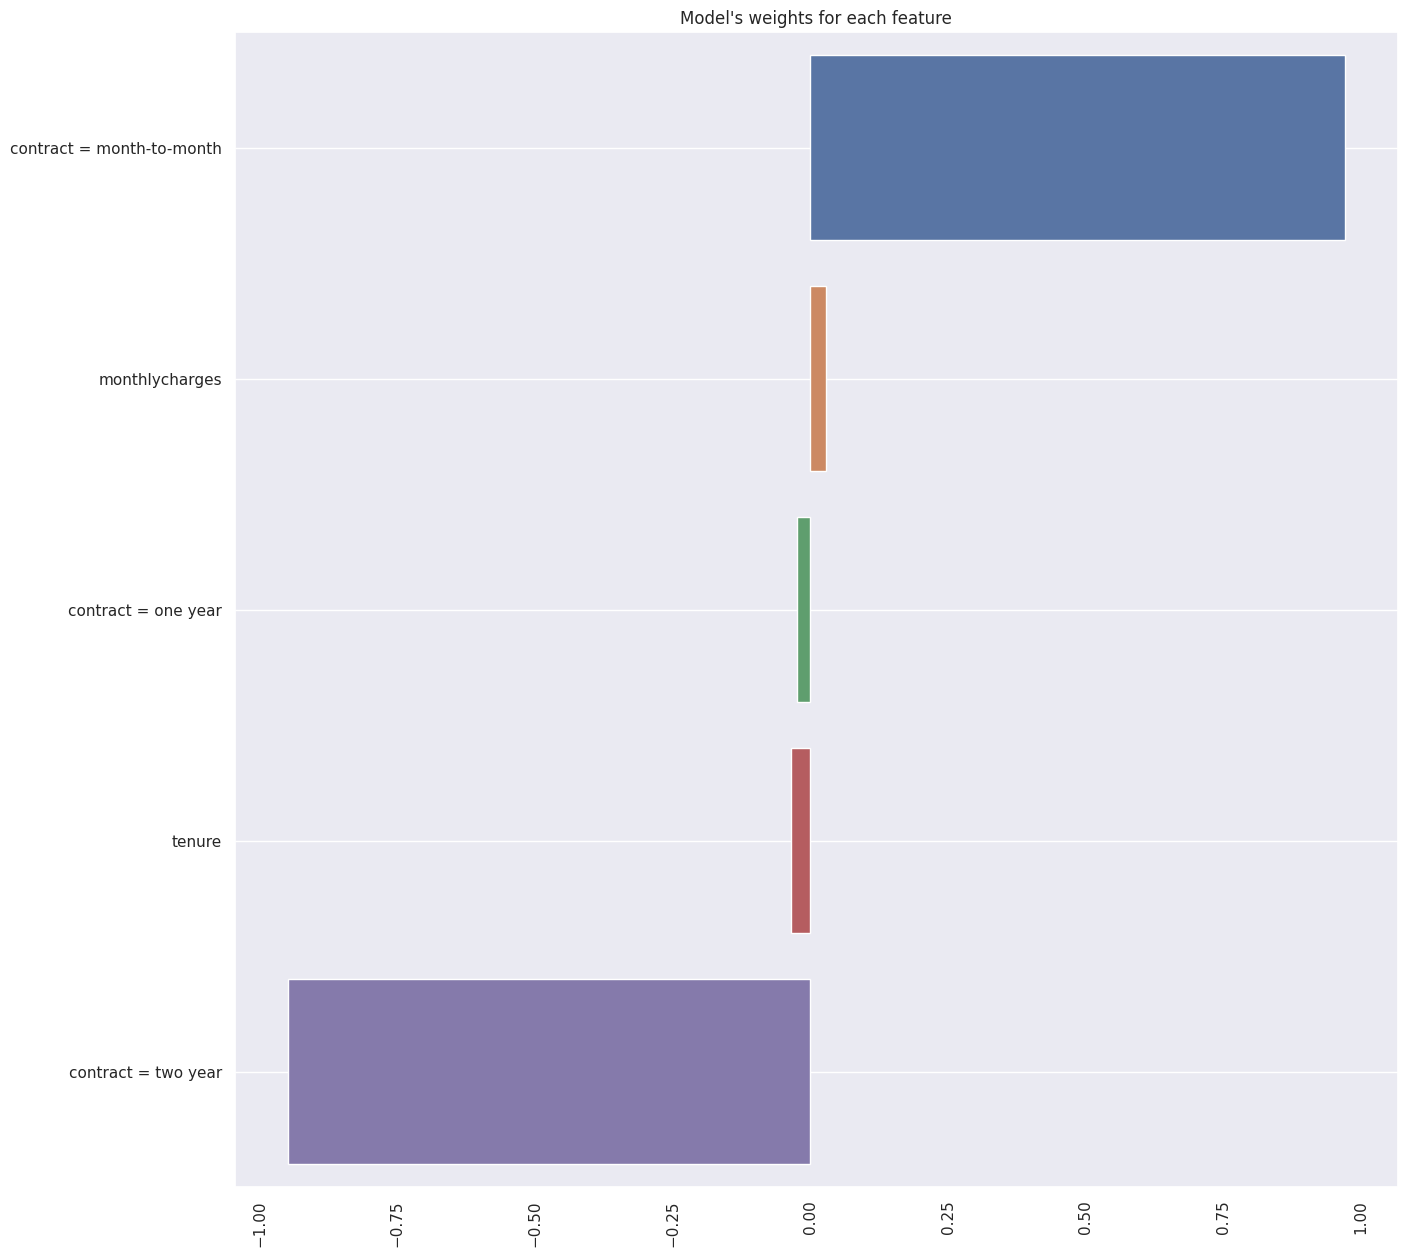

In [36]:
weights_small = pd.Series(dict(zip(dv_small.get_feature_names_out(), model_small.coef_[0]))).sort_values(ascending=False)
weights_small.index = [x.replace('=',' = ') for x in list(weights_small.index)]

plt.figure(figsize=(15,15))
plt.title("Model's weights for each feature")
sns.barplot(y=weights_small.index, x=weights_small.values)
plt.xticks(rotation=90)
ax = plt.gca()
ax.yaxis.grid(True) # Hide the horizontal gridlines
ax.xaxis.grid(False) # Show the vertical gridlines
plt.show()

In [37]:
y_pred_small = model_small.predict_proba(X_val_small)[:,1]
churn_decision_small = (y_pred_small >= 0.5)
accuracy_score(y_val,churn_decision_small)

0.7963094393186657

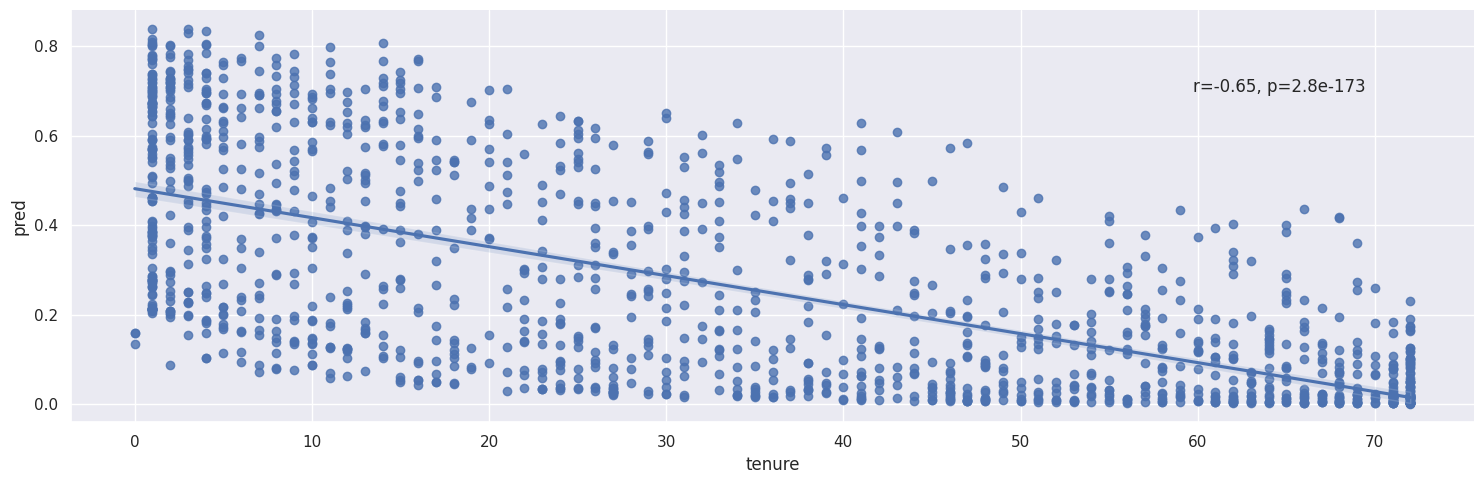

In [38]:
def annotate(data, **kws):
    r, p = sp.stats.pearsonr(df_val.tenure.values, y_pred)
    ax = plt.gca()
    ax.text(.8, .8, 'r={:.2f}, p={:.2g}'.format(r, p),
            transform=ax.transAxes)

df_val_full = pd.concat([df_val,pd.Series(y_pred)], axis=1)
df_val_full.columns = list(df_val.columns) + ['pred']

g = sns.lmplot(data = df_val_full, x='tenure', y='pred', aspect=3)
g.map_dataframe(annotate)
plt.tight_layout()
plt.show()

## 7. Using the model

In [39]:
dicts_full_train = df_full_train[categorical + numerical].to_dict(orient='records')

dv_full = DictVectorizer(sparse=True)

X_full_train = dv_full.fit_transform(dicts_full_train)
y_full_train = df_full_train.churn.values

In [40]:
# Fitting into model
model = LogisticRegression()
model.fit(X_full_train, y_full_train);

/home/pedro/.pyenv/versions/3.9.0/envs/ml_zoomcamp/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [41]:
dicts_test = df_test[categorical + numerical].to_dict(orient='records')

X_test = dv_full.transform(dicts_test)

y_pred = model.predict_proba(X_test)[:,1]

churn_decision = (y_pred >= 0.5)

score = accuracy_score(y_test,churn_decision)
score

0.8076650106458482

## Refactoring

In [42]:
def preprocess(path):
    df = pd.read_csv(path)

    df.columns = df.columns.str.lower().str.replace(' ', '_')

    categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

    for c in categorical_columns:
        df[c] = df[c].str.lower().str.replace(' ', '_')

    df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
    df.totalcharges = df.totalcharges.fillna(0)

    df.churn = (df.churn == 'yes').astype(int)

    df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
    df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)

    y_train = df_train.churn.values
    y_val = df_val.churn.values
    y_test = df_test.churn.values

    del df_train['churn']
    del df_val['churn']
    del df_test['churn']

    X_train = vectorize(df_train)
    X_val = vectorize(df_val)
    X_test = vectorize(df_test)

    return X_train, X_val, X_test, y_train, y_val, y_test

def vectorize(df):
    numerical = ['tenure', 'monthlycharges', 'totalcharges']
    categorical = ['gender','seniorcitizen','partner','dependents','phoneservice','multiplelines','internetservice','onlinesecurity','onlinebackup','deviceprotection','techsupport','streamingtv','streamingmovies','contract','paperlessbilling','paymentmethod']
    
    dv = DictVectorizer(sparse=False)

    dict = df[categorical + numerical].to_dict(orient='records')
    X = dv.fit_transform(dict)

    return X

def train_model(X_train, y_train):
    model = LogisticRegression()
    model.fit(X_train, y_train)

    return model

def evaluate_model(model, X_val, y_val, threshold=0.5):
    y_pred = model.predict_proba(X_val)[:, 1]
    churn_decision = (y_pred >= threshold)
    score = (y_val == churn_decision).mean()
    
    return score

In [43]:
X_train, X_val, X_test, y_train, y_val, y_test = preprocess('/home/pedro/my_project_dir/ml_course/WA_Fn-UseC_-Telco-Customer-Churn.csv')

model = train_model(X_train, y_train)
y_pred = model.predict_proba(X_val)[:, 1]

## What are thresholds? 
Recall that in our model, we made it such that if y_pred >= 0.5, it would be counted as 1. 
However, that probability can be adjusted such that we can make stricter predictions or more lenient predictions. 

For example, instead of 0.5, we can make it such that anything from 0.3 onwards would be counted as 1, or anything from 0.74 would be counted as 1. 

0.5151515151515152


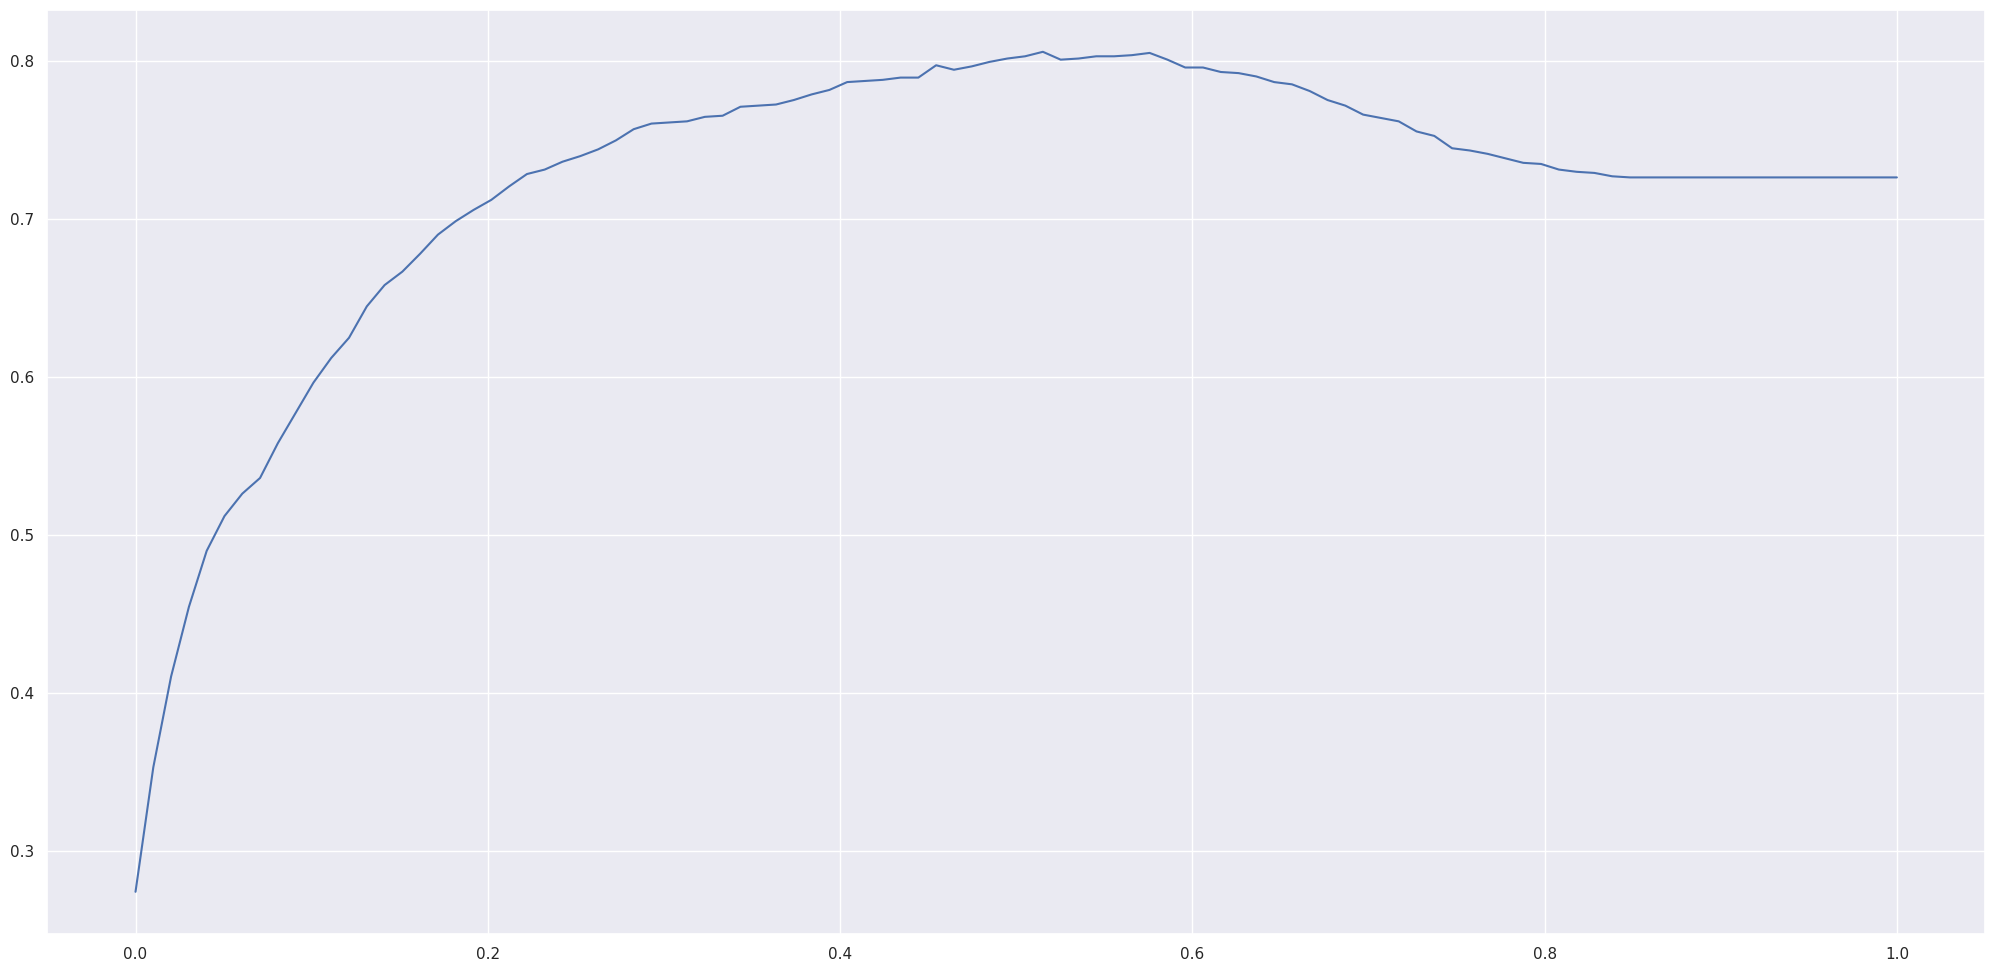

In [44]:
thresholds = np.linspace(0,1,100)
y = []
for i,t in enumerate(thresholds):
    churn_decision = (y_pred >= t)
    score = accuracy_score(y_val,churn_decision)
    y.append(score)

results = pd.Series(dict(zip(thresholds,y)))
results.plot()
print(results.idxmax())

Afterthoughts of accuracy:

Accuracy does not tell us how good a model is if there is a class imbalance. Only with balanced data (such as data that is 50/50, or a bit more varied than that) would accuracy be a good metric to use. We have to look at other evaluation metrics

## 8. Confusion table

* Different types of errors and correct decisions
* Arranging them in a table

Basics of a confusion table/matrix (as some people would call it): 

There will be 2 possible scenarios when there is a prediction of no churn:
1. The customer indeed didn't churn - also known as a true negative
2. The customer actually churned - also knows as a false negative

The same thing will happen when there is a prediction of churn:
1. The customer indeed churned - also known as a true positive
2. The customer actually didn't churn - also known as a false positive 

These four scenarios form a confusion table/matrix.

In [45]:
# Actual positives and negatives 
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [46]:
# Predictions with threshold 
t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [47]:
# Four components of the confusion matrix
tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()

fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

In [48]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_val, y_pred>0.5)

array([[922, 101],
       [176, 210]])

In [49]:
# Creating the confusion matrix itself 
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])
confusion_matrix

array([[922, 101],
       [176, 210]])

In [50]:
# Percentage, rounded off to 2 dp 
(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.65, 0.07],
       [0.12, 0.15]])

## 9. Precision and Recall

In [51]:
# Precision 
p = tp / (tp + fp)
p

0.6752411575562701

In [52]:
r = tp / (tp + fn)
r

0.5440414507772021

In [53]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred>=0.5))

              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1023
           1       0.68      0.54      0.60       386

    accuracy                           0.80      1409
   macro avg       0.76      0.72      0.74      1409
weighted avg       0.79      0.80      0.80      1409



## Precision vs Recall - when do we use it? 
Answer: It depends on the situation at hand. 

Sometimes, we would need to focus on precision a bit more than that of recall, and sometimes vice versa. 

For example, we would need to focus more on recall if 

## 10. ROC Curves

### TPR and FPR

In [54]:
tpr = tp / (tp + fn)
tpr

0.5440414507772021

In [55]:
fpr = fp / (fp + tn)
fpr

0.09872922776148582

In [56]:
def roc_curve(y_val,y_pred):
    scores = []

    # Creating an array of evenly-spaced probabilities from 0 to 1 (aka 0, 0.1, 0.2, ..., 0.99, 1)
    thresholds = np.linspace(0, 1, 101)

    # Printing true positives & negatives, false positives & negatives for each rate 
    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)
        
        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()
        
        # List of tuples is created per threshold
        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

    plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR')
    plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR')
    plt.style.use('seaborn-bright')
    plt.rcParams['figure.figsize'] = [20, 10]
    plt.rcParams['font.size'] = 24
    plt.legend()
    return None

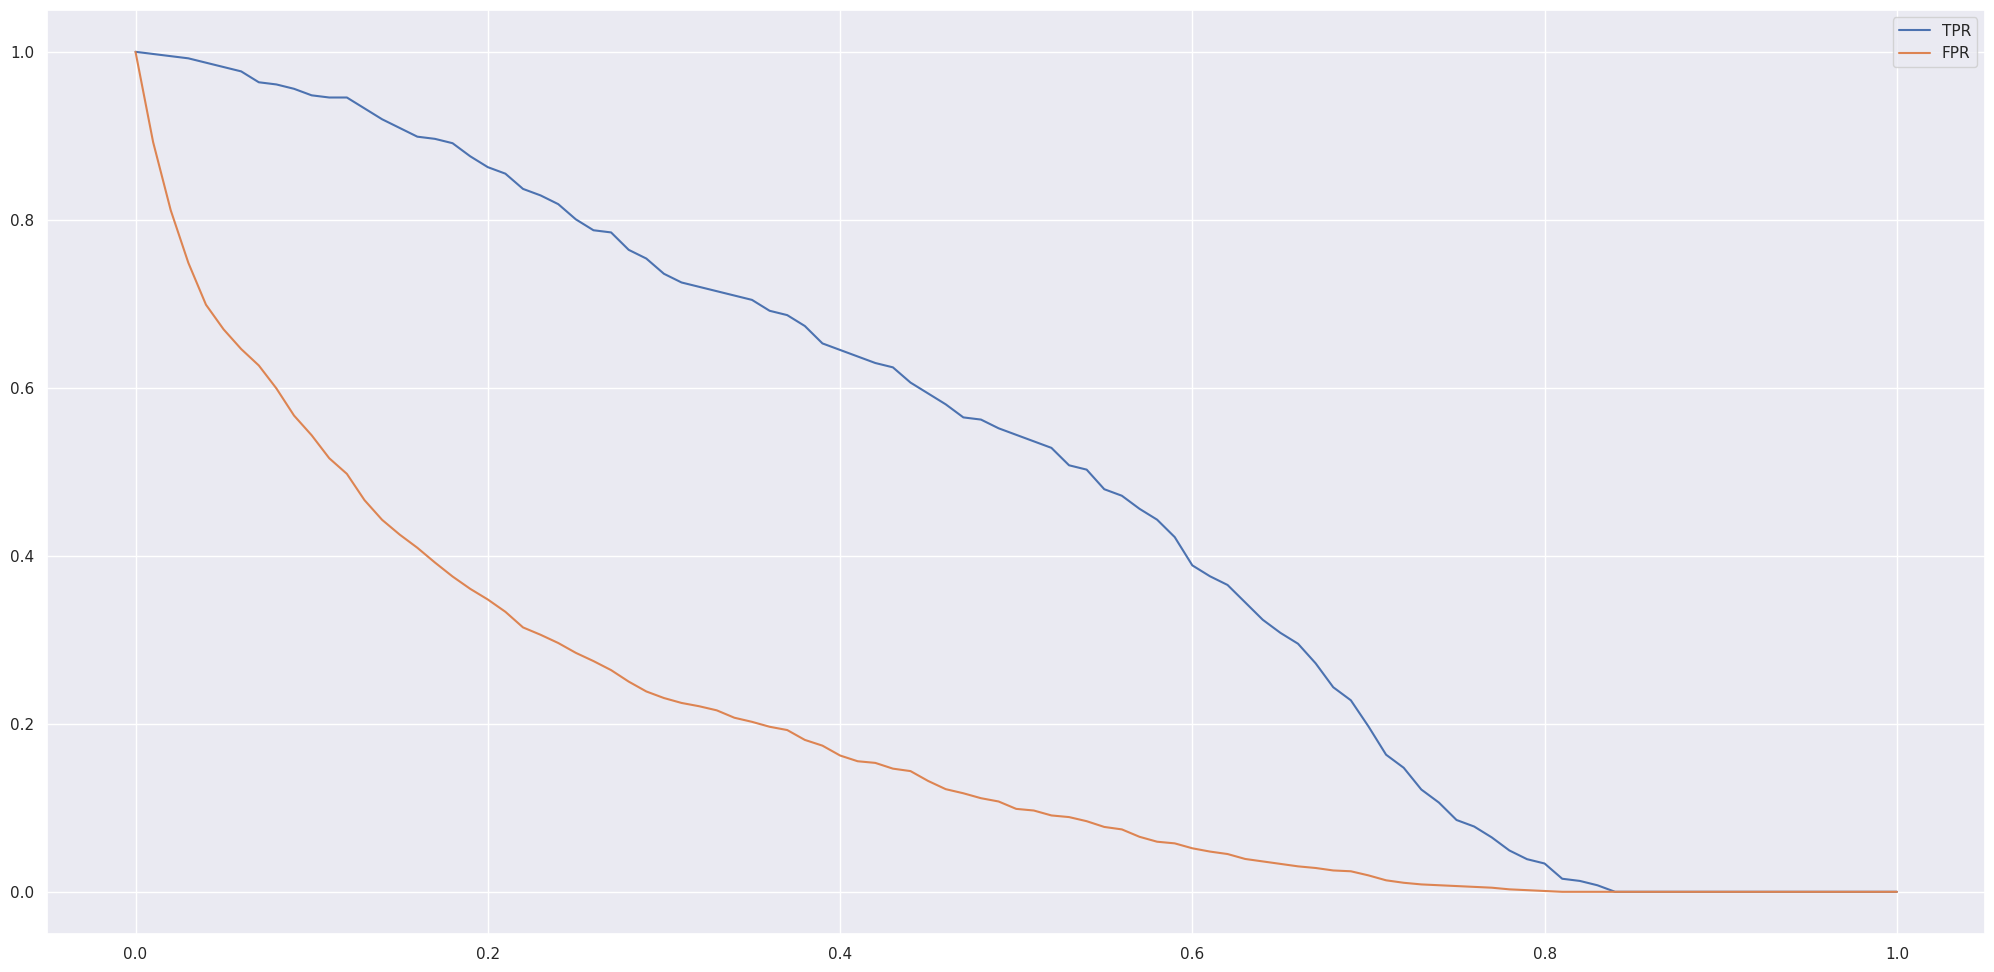

In [57]:
roc_curve(y_val,y_pred)

### Random model
We will be using this model as a baseline.

In [58]:
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size=len(y_val))
((y_rand >= 0.5) == y_val).mean()

0.5017743080198722

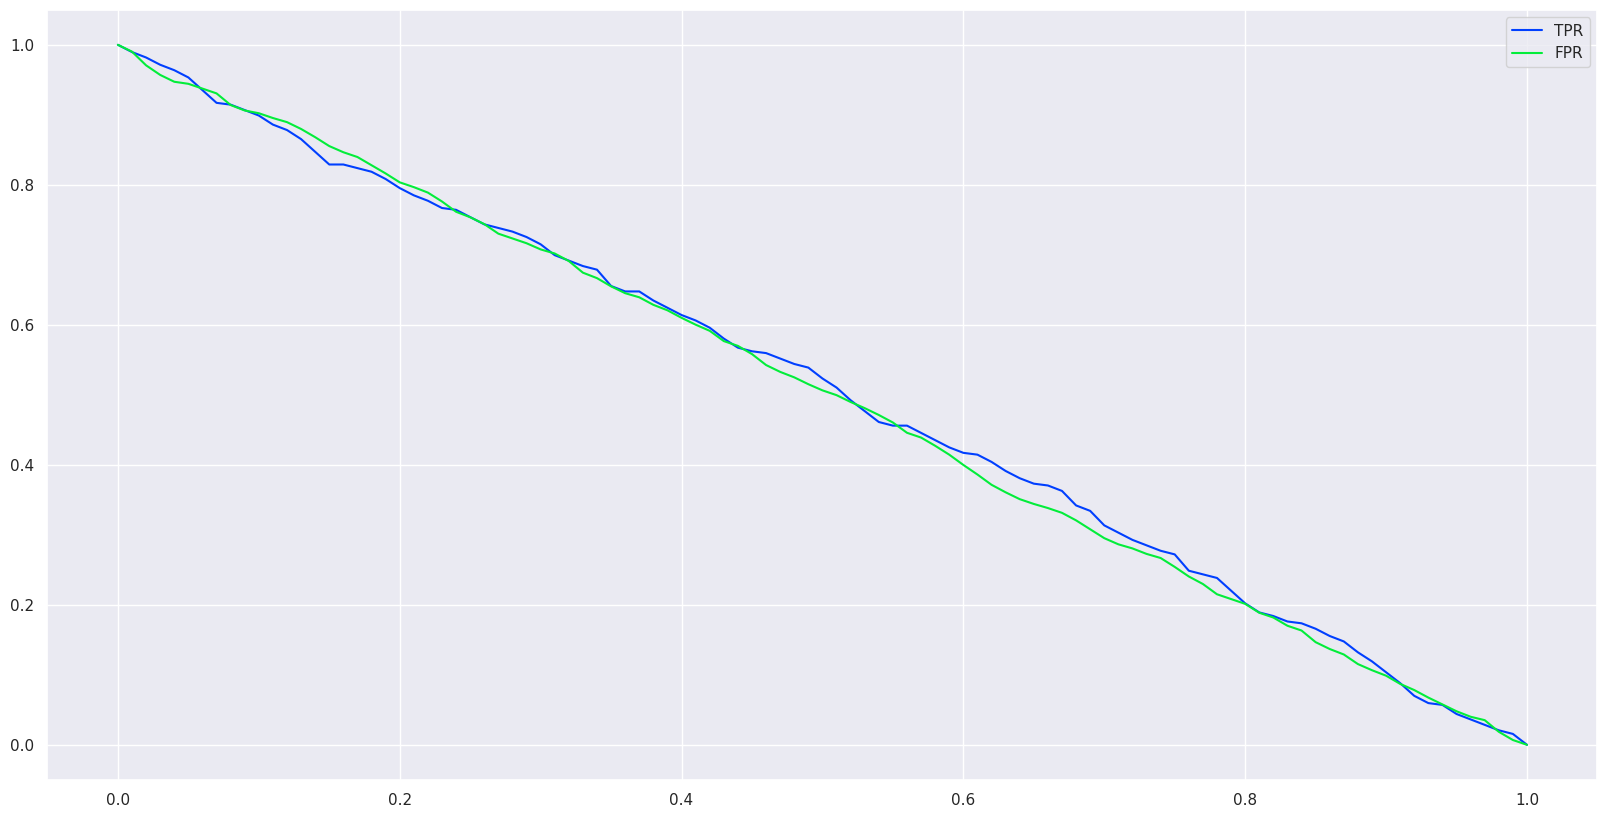

In [59]:
roc_curve(y_val,y_rand)

### Ideal model

In [60]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()
num_neg, num_pos

(1023, 386)

In [61]:
# Repeating the 0 and 1 values according to the num_neg and num_pos 
y_ideal = np.repeat([0, 1], [num_neg, num_pos])
y_ideal

# We create a ideal prediction dataset with values corresponding to 0 or 1 with regards to the threshold
y_ideal_pred = np.linspace(0, 1, len(y_val))

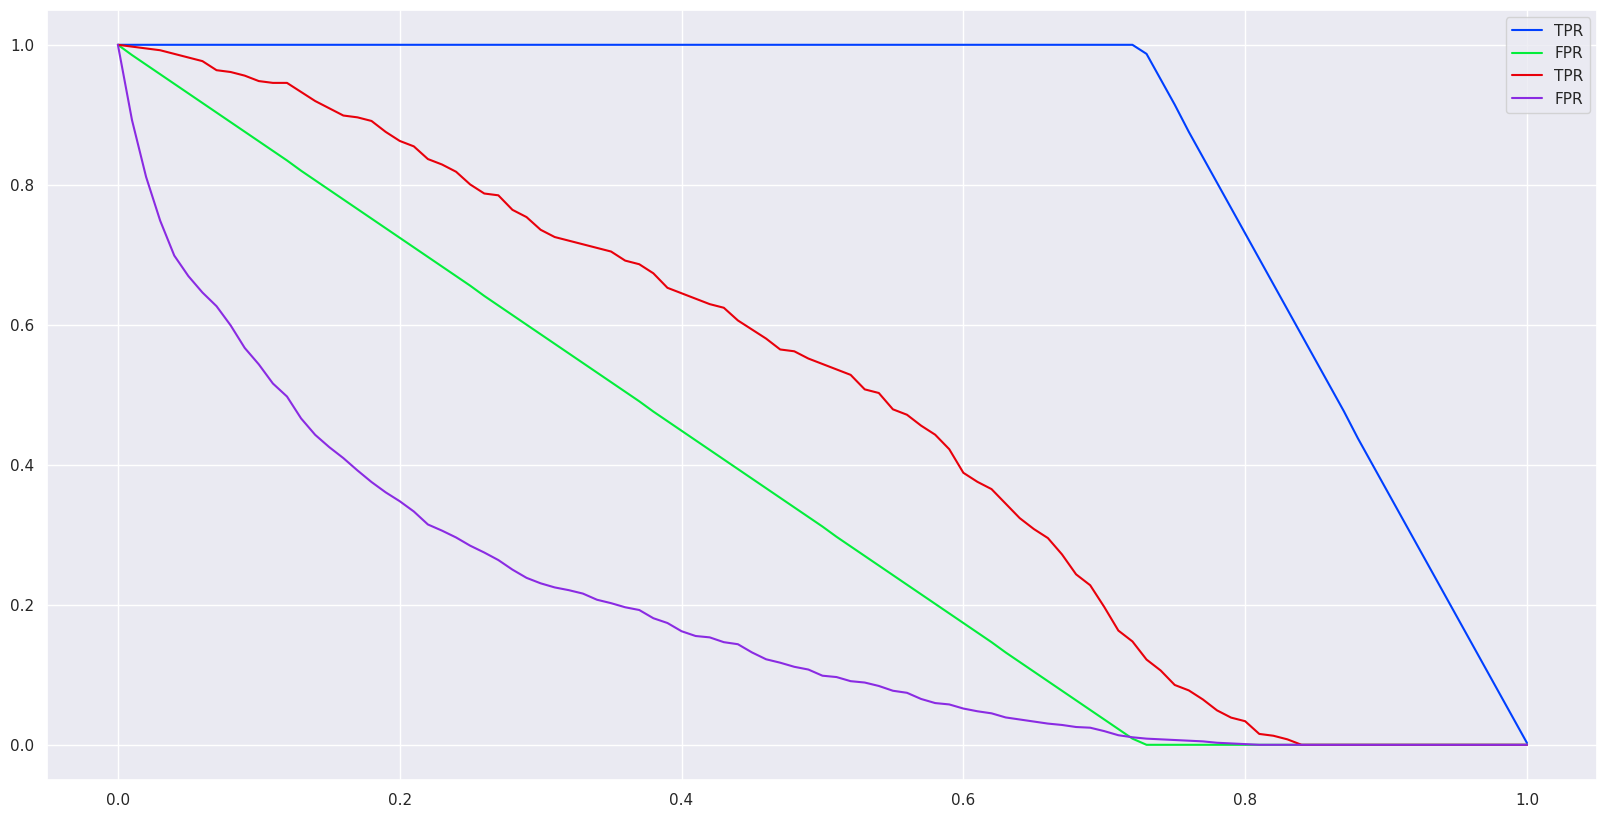

In [62]:
roc_curve(y_ideal,y_ideal_pred)
roc_curve(y_val,y_pred)
plt.show()

In [63]:
def roc_curve(y_val,y_pred, label=''):
    scores = []

    # Creating an array of evenly-spaced probabilities from 0 to 1 (aka 0, 0.1, 0.2, ..., 0.99, 1)
    thresholds = np.linspace(0, 1, 101)

    # Printing true positives & negatives, false positives & negatives for each rate 
    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)
        
        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()
        
        # List of tuples is created per threshold
        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

    plt.style.use('seaborn-bright')
    plt.rcParams['figure.figsize'] = [10, 10]
    plt.rcParams['font.size'] = 24

    plt.plot(df_scores.fpr, df_scores.tpr, label=label)
    if label != '':
        plt.legend()
    else:
        pass
    return None

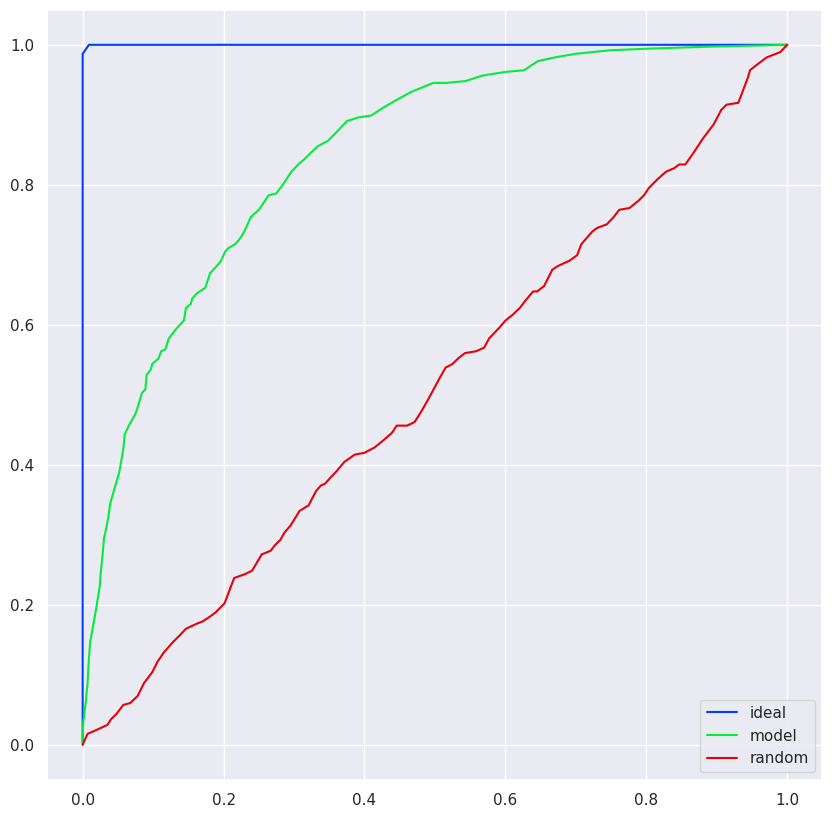

In [64]:
roc_curve(y_ideal,y_ideal_pred, 'ideal')
roc_curve(y_val,y_pred,'model')
roc_curve(y_val,y_rand,'random')

plt.show()

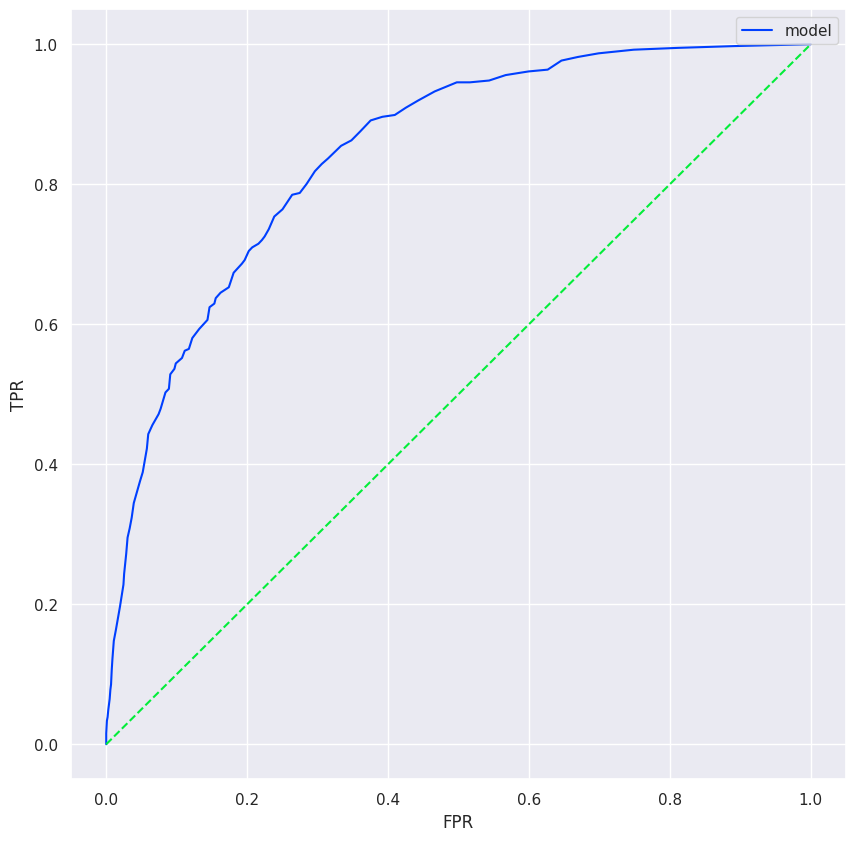

In [65]:
roc_curve(y_val,y_pred,'model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

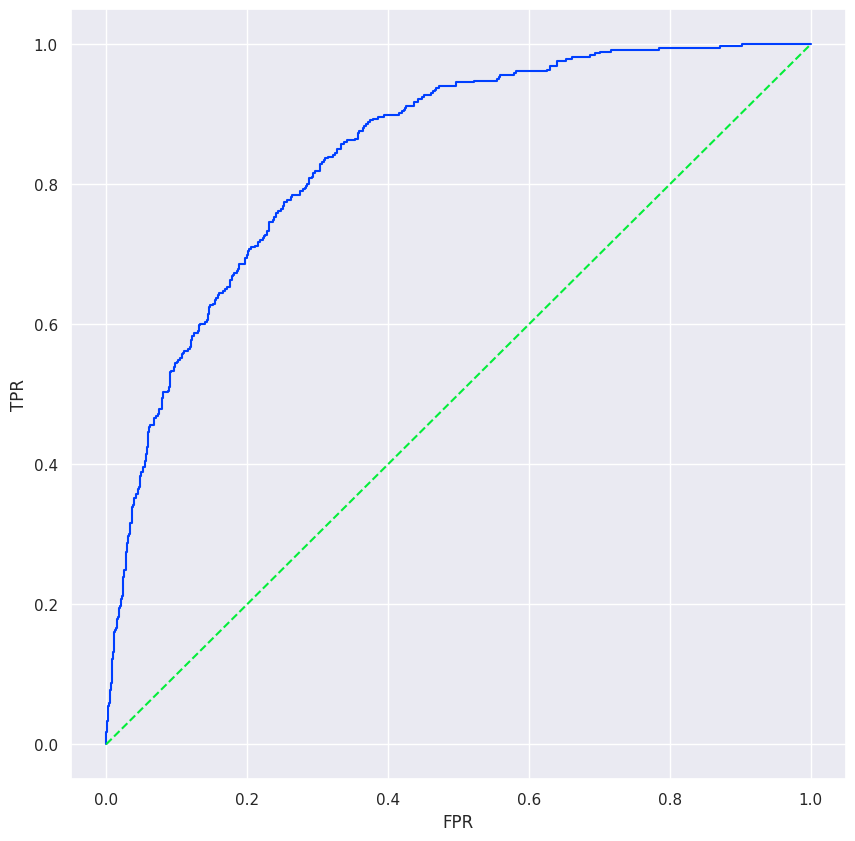

In [66]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_val,y_pred)
plt.plot(fpr, tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

### 10.1 ROC AUC

* Area under the ROC curve - useful metric
* Interpretation of AUC

The area under the curve is a very useful for the metric itself. To calculate the AUC, we will usually have to use calculus for this - but sklearn has a AUC function that doesn't need us to calculate the AUC. 

We should, however, consider what the value of the AUC should be: 
1. It should definitely be more than 0.5 - the random model* that we did has a area of 0.5. If it is less than 0.5, there is definitely a problem with the curve itself.
2. It should be as close to 1 as possible. The AUC of the ideal model is 1, and while we can't always achieve the ideal model, we should bring it as close to the ideal model as possible. 

*= Reason why the random model has an area of 0.5 is because we consider it as a straight line. This means that we can calculate the area under the line itself as a 'triangle'. At FPR = 1, TPR also = 1, therefore the 'triangle' random model has a length of 1 and height of 1. Area of triangle = 0.5 * length * height, therefore AUC = 0.5.

In [67]:
from sklearn.metrics import auc

In [68]:
auc(fpr, tpr)

0.843850505725819

In [69]:
from sklearn.metrics import roc_auc_score

In [70]:
roc_auc_score(y_val, y_pred)

0.843850505725819

Ok, but what does AUC actually tell us? 

AUC tells us the probability that a randomly selected positive example has a higher score than a randomly selected negative exmaple.

In [71]:
neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]

In [72]:
# Using numpy instead
n = 50000

np.random.seed(1)
pos_ind = np.random.randint(0, len(pos), size=n)
neg_ind = np.random.randint(0, len(neg), size=n)

(pos[pos_ind] > neg[neg_ind]).mean()

# Do note that the size of n will influence how close the AUC score is to the actual AUC score.

0.84646

## 11. Cross-validation

In [73]:
def preprocess(path):
    df = pd.read_csv(path)

    df.columns = df.columns.str.lower().str.replace(' ', '_')

    categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

    for c in categorical_columns:
        df[c] = df[c].str.lower().str.replace(' ', '_')

    df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
    df.totalcharges = df.totalcharges.fillna(0)

    df.churn = (df.churn == 'yes').astype(int)

    df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
    df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)

    y_train = df_train.churn.values
    y_val = df_val.churn.values
    y_test = df_test.churn.values

    del df_train['churn']
    del df_val['churn']
    del df_test['churn']

    return df_train, df_val, df_test, y_train, y_val, y_test

def vectorize(df):
    numerical = ['tenure', 'monthlycharges', 'totalcharges']
    categorical = ['gender','seniorcitizen','partner','dependents','phoneservice','multiplelines','internetservice','onlinesecurity','onlinebackup','deviceprotection','techsupport','streamingtv','streamingmovies','contract','paperlessbilling','paymentmethod']
    
    dv = DictVectorizer(sparse=False)

    dict = df[categorical + numerical].to_dict(orient='records')
    X = dv.fit_transform(dict)

    return X, dv

def train_model(df_train, y_train, C=1):
    X_train, dv = vectorize(df_train)
    model = LogisticRegression(C=C, max_iter=10000)
    model.fit(X_train, y_train)

    return model, dv

def predict_model(df, dv, model):
    numerical = ['tenure', 'monthlycharges', 'totalcharges']
    categorical = ['gender','seniorcitizen','partner','dependents','phoneservice','multiplelines','internetservice','onlinesecurity','onlinebackup','deviceprotection','techsupport','streamingtv','streamingmovies','contract','paperlessbilling','paymentmethod']
    
    dicts = df[categorical + numerical].to_dict(orient='records')
    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [74]:
df_train, df_val, df_test, y_train, y_val, y_test = preprocess('/home/pedro/my_project_dir/ml_course/WA_Fn-UseC_-Telco-Customer-Churn.csv')

model, dv = train_model(df_train, y_train)
y_pred = predict_model(df_val, dv, model)

In [ ]:
from sklearn.model_selection import KFold
from tqdm.auto import tqdm

n_splits = 5

for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        # the k-fold split uses index to shuffle the data
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
        
        # y values come from dataset
        y_train = df_train.churn.values
        y_val = df_val.churn.values
        
        # training and predicting
        model, dv = train_model(df_train, y_train, C=C)
        y_pred = predict_model(df_val, dv, model)
        
        # AUC
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/7 [00:00<?, ?it/s]

C=0.001 0.825 +- 0.009
C=0.01 0.839 +- 0.009
